# Hybrid Quantum Neural Networks  
The example below highlights a hybrid quantum nerual network workflow iwth CUDA-Q and PyTorch where both layers can GPU accelerated to maximize performance.  
We perform binary classification on the MNIST dataset where data flows through the neural network architecture to the quantum circuit whose output is used to classify hand wirtten digits.

In [1]:
import cudaq
from cudaq import spin

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torchvision

from sklearn.model_selection import train_test_split

torch.manual_seed(22)
cudaq.set_random_seed(44)

In [2]:
# Set CUDA-Q and PyTorch to run on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudaq.set_target('nvidia')

# # CPU
# device = torch.device('cpu')
# cudaq.set_target('qpp-cpu')

In [3]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used

    Args:
        target_digits (list): digits to perform classification of
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set

    Returns:
        dataset in train, test format with targets

    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307), (0.3081))])

    dataset = datasets.MNIST("./data",
                             train=True,
                             download=True,
                             transform=transform)

    # Filter out the required labels.
    idx = (dataset.targets == target_digits[0]) | (dataset.targets
                                                   == target_digits[1])
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]

    # Select a subset based on number of datapoints specified by sample_count.
    subset_indices = torch.randperm(dataset.data.size(0))[:sample_count]

    x = dataset.data[subset_indices].float().unsqueeze(1).to(device)

    y = dataset.targets[subset_indices].to(device).float().to(device)

    # Relabel the targets as a 0 or a 1.
    y = torch.where(y == min(target_digits), 0.0, 1.0)

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=test_size /
                                                        100,
                                                        shuffle=True,
                                                        random_state=42)

    return x_train, x_test, y_train, y_test

In [4]:
# Classical parameters.

sample_count = 1000  # Total number of images to use.
target_digits = [6, 9]  # Hand written digits to classify.
test_size = 30  # Percentage of dataset to be used for testing.
classification_threshold = 0.5  # Classification boundary used to measure accuracy.
epochs = 1000  # Number of epochs to train for.

# Quantum parmeters.

qubit_count = 1
hamiltonian = spin.z(0)  # Measurement operator.
shift = torch.tensor(torch.pi / 2)  # Magnitude of parameter shift.

In [5]:
x_train, x_test, y_train, y_test = prepare_data(target_digits, sample_count, test_size)

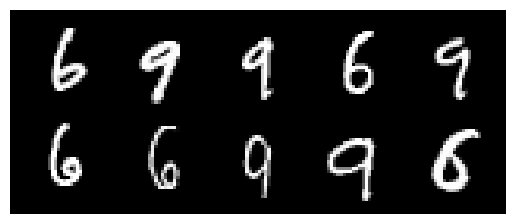

In [6]:
# Plot some images from the training set to visualise.
if device != 'cpu':
    sample_to_plot = x_train[:10].to(torch.device('cpu'))
else:
    sample_to_plot = x_train[:10]

grid_img = torchvision.utils.make_grid(sample_to_plot,
                                       nrow=5,
                                       padding=3,
                                       normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [7]:
shift = torch.tensor(torch.pi/100).to(device) # SPSA
# shift = torch.tensor(torch.pi / 2)  # 유한 차분법

class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):

            qubits = cudaq.qvector(qubit_count)

            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

        noise_model = cudaq.NoiseModel()
        depolarizing_channel = cudaq.DepolarizationChannel(0.1)
        noise_model.add_channel("rx", [0], depolarizing_channel)
        noise_model.add_channel('ry', [1], depolarizing_channel)
        self.noise_model = noise_model

    def run(self, theta_vals: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on inputs which moves thetas from GPU to CPU.

        qubit_count = [self.qubit_count for _ in range(theta_vals.shape[0])]

        # results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count, theta_vals, noise_model=self.noise_model)
        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count, theta_vals)
        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod # staticmethod로 인해서 외부에서 인스턴스 생성 없이 바로 사용이 가능함
    def forward(ctx, thetas: torch.tensor, quantum_circuit, shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)

        ctx.save_for_backward(thetas, exp_vals)

        return exp_vals

    # @staticmethod # Gradient descent via finite difference
    # def backward(ctx, grad_output):
    #     """Backward pass computation via finite difference"""

    #     thetas, _ = ctx.saved_tensors

    #     gradients = torch.zeros(thetas.shape, device=device)

    #     for i in range(thetas.shape[1]):

    #         thetas_plus = thetas.clone()
    #         thetas_plus[:, i] += ctx.shift
    #         exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)

    #         thetas_minus = thetas.clone()
    #         thetas_minus[:, i] -= ctx.shift
    #         exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

    #         gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)

    #     gradients = torch.mul(grad_output, gradients)

    #     return gradients, None, None

    @staticmethod
    def backward(ctx, grad_output): # SPSA 방식으로, 얘를 쓸 때는 shift 값을 작게 줘야 하며 학습진행에 따라 decay를 주어야 함
        """Backward pass computation via SPSA (Fixed Shape Error)"""

        thetas, _ = ctx.saved_tensors
        shift = ctx.shift
        
        # 1. 섭동 벡터 생성
        delta = torch.randint(0, 2, thetas.shape, device=thetas.device).float() * 2 - 1 # -1 또는 1

        # 2. 파라미터 섭동
        thetas_plus = thetas + shift * delta
        thetas_minus = thetas - shift * delta

        # 3. 회로 실행
        exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)
        exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

        # 4. 그라디언트 계산 [수정된 부분]
        # 아까 에러 원인: (Batch) - (Batch) = (Batch) 였음
        # 수정: (Batch) -> (Batch, 1)로 바꿔서 브로드캐스팅 가능하게 함
        diff = (exp_vals_plus - exp_vals_minus).view(-1, 1) 
        
        # 이제 (Batch, 1) * (Batch, Params) 연산이 정상 작동함
        gradient_est = diff / (2 * shift) * delta

        # grad_output 차원도 안전하게 맞춤
        if grad_output.dim() == 1:
            grad_output = grad_output.view(-1, 1)

        gradients = torch.mul(grad_output, gradient_est)

        return gradients, None, None


class QuantumLayer(nn.Module):
    """ 양자 회로를 양자 신경망 레이어로 활용 """

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator, shift = torch.tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):
        result = QuantumFunction.apply(input, self.quantum_circuit, self.shift)
        # apply를 하면 forward와 backward가 자동으로 호출됨
        # QuantumFunction의 forward, backward 메서드가 staticmethod로 정의되어 있어서 인스턴스 생성 없이 바로 사용이 가능함
    

        return result

class Hybrid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hybrid_QNN, self).__init__()

        self.classical_layer = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, shift)

    def forward(self, x):

        x = x.view(-1, 28 * 28)  # Turns images into vectors.

        x = self.classical_layer(x)

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = torch.sigmoid(self.quantum(x))

        return x.view(-1)

In [8]:
def accuracy_score(y, y_hat):
    return sum((y == (y_hat >= classification_threshold))) / len(y)

In [37]:
hybrid_model = Hybrid_QNN().to(device)


optimizer = optim.Adadelta(hybrid_model.parameters(),
                           lr=0.001,
                           weight_decay=0.8)

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in range(epochs):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(x_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    hybrid_model.eval()
    with torch.no_grad():

        y_hat_test = hybrid_model(x_test).to(device)

        test_cost = loss_function(y_hat_test, y_test).to(device)

        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        testing_cost.append(test_cost.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_cost.item():.4f}.. "
            f"Test loss: {test_cost.item():.4f}.. "
            f"Train Accuracy: {training_accuracy[-1]:.4f}.. "
            f"Test Accuracy: {testing_accuracy[-1]:.4f}")
        

Epoch 10/1000.. Train loss: 0.7684.. Test loss: 0.7806.. Train Accuracy: 0.5171.. Test Accuracy: 0.5133
Epoch 20/1000.. Train loss: 0.7452.. Test loss: 0.7594.. Train Accuracy: 0.5257.. Test Accuracy: 0.5300
Epoch 30/1000.. Train loss: 0.7005.. Test loss: 0.7161.. Train Accuracy: 0.5643.. Test Accuracy: 0.5600
Epoch 40/1000.. Train loss: 0.6391.. Test loss: 0.6588.. Train Accuracy: 0.6457.. Test Accuracy: 0.6167
Epoch 50/1000.. Train loss: 0.5794.. Test loss: 0.6016.. Train Accuracy: 0.7286.. Test Accuracy: 0.7100
Epoch 60/1000.. Train loss: 0.5357.. Test loss: 0.5582.. Train Accuracy: 0.7743.. Test Accuracy: 0.7533
Epoch 70/1000.. Train loss: 0.5042.. Test loss: 0.5270.. Train Accuracy: 0.8100.. Test Accuracy: 0.7867
Epoch 80/1000.. Train loss: 0.4818.. Test loss: 0.5050.. Train Accuracy: 0.8286.. Test Accuracy: 0.8000
Epoch 90/1000.. Train loss: 0.4651.. Test loss: 0.4886.. Train Accuracy: 0.8471.. Test Accuracy: 0.8233
Epoch 100/1000.. Train loss: 0.4524.. Test loss: 0.4761.. Train 

In [30]:
hybrid_model = Hybrid_QNN().to(device)

optimizer = optim.Adadelta(hybrid_model.parameters(),
                           lr=0.001,
                           weight_decay=0.8)

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in range(epochs):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(x_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    hybrid_model.eval()
    with torch.no_grad():

        y_hat_test = hybrid_model(x_test).to(device)

        test_cost = loss_function(y_hat_test, y_test).to(device)

        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        testing_cost.append(test_cost.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_cost.item():.4f}.. "
            f"Test loss: {test_cost.item():.4f}.. "
            f"Train Accuracy: {training_accuracy[-1]:.4f}.. "
            f"Test Accuracy: {testing_accuracy[-1]:.4f}")

Epoch 10/1000.. Train loss: 0.7342.. Test loss: 0.7631.. Train Accuracy: 0.5329.. Test Accuracy: 0.4933
Epoch 20/1000.. Train loss: 0.7251.. Test loss: 0.7530.. Train Accuracy: 0.5371.. Test Accuracy: 0.5033
Epoch 30/1000.. Train loss: 0.7138.. Test loss: 0.7406.. Train Accuracy: 0.5457.. Test Accuracy: 0.5167
Epoch 40/1000.. Train loss: 0.6999.. Test loss: 0.7256.. Train Accuracy: 0.5543.. Test Accuracy: 0.5333
Epoch 50/1000.. Train loss: 0.6831.. Test loss: 0.7081.. Train Accuracy: 0.5771.. Test Accuracy: 0.5500
Epoch 60/1000.. Train loss: 0.6639.. Test loss: 0.6884.. Train Accuracy: 0.5943.. Test Accuracy: 0.5633
Epoch 70/1000.. Train loss: 0.6435.. Test loss: 0.6670.. Train Accuracy: 0.6214.. Test Accuracy: 0.5800
Epoch 80/1000.. Train loss: 0.6227.. Test loss: 0.6444.. Train Accuracy: 0.6557.. Test Accuracy: 0.6233
Epoch 90/1000.. Train loss: 0.6016.. Test loss: 0.6207.. Train Accuracy: 0.6871.. Test Accuracy: 0.6533
Epoch 100/1000.. Train loss: 0.5807.. Test loss: 0.5965.. Train 

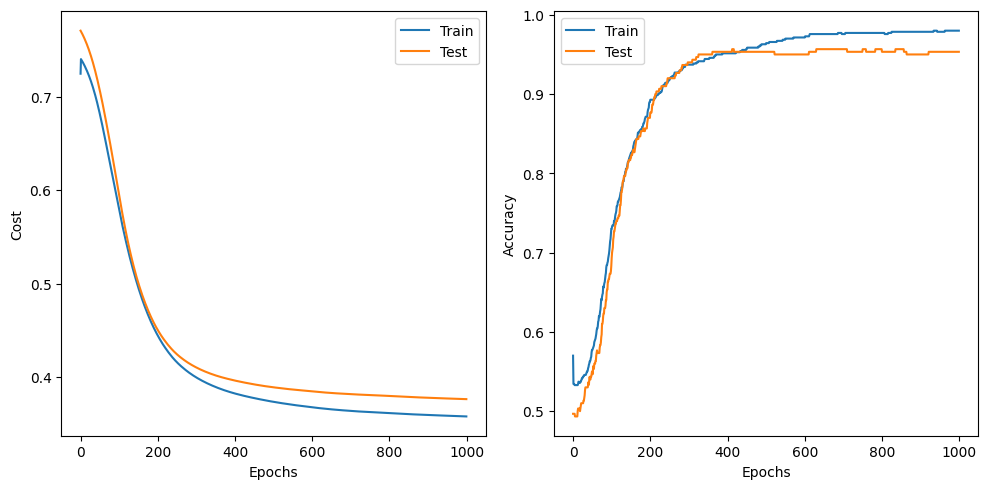

In [31]:
####################################
# Parameter-shift rule로 학습한 결과 # shit를 pi/2로 줌
####################################


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(torch.tensor(training_accuracy), label='Train')
plt.plot(torch.tensor(testing_accuracy), label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

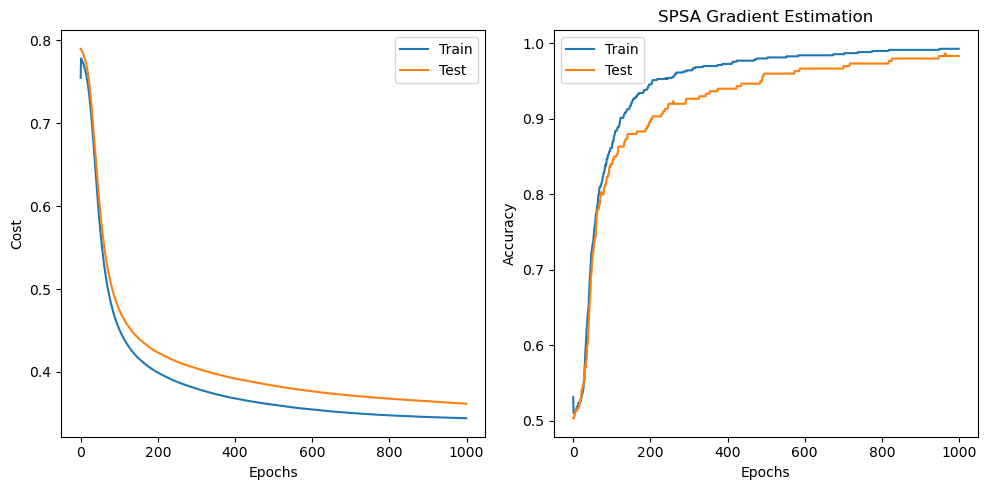

In [38]:
##################################################
# SPSA gradient estimation으로 학습한 결과 # # shift를 pi/100으로 줌
##################################################

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(torch.tensor(training_accuracy), label='Train')
plt.plot(torch.tensor(testing_accuracy), label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SPSA Gradient Estimation')
plt.legend()

plt.tight_layout()
plt.show()

# Parameterized Circuit - image classfication

In [9]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# 텐서가 GPU에 있다면 CPU로 이동시키고 NumPy로 변환해야 합니다.
# 예시 텐서 (실제 데이터 텐서로 대체 필요)
# input_tensor = torch.randn(700, 1, 28, 28).to(device) 


def apply_pca_to_data(input_tensor: torch.Tensor, target_dim: int) -> torch.Tensor:
    # 1. GPU -> CPU 및 NumPy 변환
    if input_tensor.is_cuda:
        data_np = input_tensor.cpu().numpy()
    else:
        data_np = input_tensor.numpy()

    # 2. 데이터 평탄화 (Flattening)
    # (700, 1, 28, 28) -> (700, 784)
    N_samples = data_np.shape[0]
    data_flat = data_np.reshape(N_samples, -1) 
    
    # 3. PCA 적용 및 차원 축소
    pca = PCA(n_components=target_dim)
    data_reduced = pca.fit_transform(data_flat) # (700, TARGET_DIM)
    
    # 4. 축소된 데이터를 다시 PyTorch 텐서로 변환
    # 변환된 데이터는 일반적으로 float64이므로, float32로 변경해주는 것이 좋습니다.
    output_tensor = torch.tensor(data_reduced, dtype=torch.float32)
    
    # 원래 텐서가 위치했던 device로 이동 (예: GPU)
    output_tensor = output_tensor.to(input_tensor.device) 
    
    # PCA 설명 분산 비율 확인 (선택 사항)
    print(f"PCA로 설명 가능한 분산 비율: {np.sum(pca.explained_variance_ratio_):.4f}")

    return output_tensor

# 사용 예시 (입력 텐서를 'train_data'라고 가정)
# --- 설정 ---
TARGET_DIM = 10  # 목표 차원. 큐비트 수에 맞춰 2, 4, 8 등으로 설정합니다.
# -------------
reduced_data = apply_pca_to_data(x_train, TARGET_DIM)
print(reduced_data.shape) # 기대 출력: torch.Size([700, 4])

PCA로 설명 가능한 분산 비율: 0.5489
torch.Size([700, 10])


In [10]:
scaled = (reduced_data + reduced_data.min()*-1) / (reduced_data.max() - reduced_data.min()) *  np.pi

In [11]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, input_data: np.ndarray, weights: np.ndarray):

            qubits = cudaq.qvector(qubit_count)

            # Embedding Layer
            for q in range(qubit_count):
                ry(input_data[q], qubits[q])

            for q in range(qubit_count):
                rx(weights[q], qubits[q])

            # x.ctrl(qubits[1], qubits[0])
            for q in range(qubit_count):
                x.ctrl(qubits[q], qubits[(q + 1)%qubit_count])

        

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

        noise_model = cudaq.NoiseModel()
        depolarizing_channel = cudaq.DepolarizationChannel(0.01)
        noise_model.add_channel("rx", [0], depolarizing_channel)
        noise_model.add_channel('ry', [0], depolarizing_channel)
        self.noise_model = noise_model

    def run(self, input_data: torch.tensor, weights: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on inputs which moves thetas from GPU to CPU.

        batch_size = input_data.shape[0]

        # 1. qubit_count 리스트 생성 (배치 크기만큼)
        qubit_counts = [self.qubit_count for _ in range(batch_size)]

        # 2. Weights 확장 (Broadcasting)
        # weight_vals는 1차원 텐서지만, cudaq.observe에 넣을 때는 입력 데이터와 
        # 짝을 맞추기 위해 (Batch, Weight_Dim) 형태로 늘려줍니다.
        weight_vals_expanded = weights.expand(batch_size, -1).contiguous()

        # results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count, theta_vals, noise_model=self.noise_model)
        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_counts, input_data, weight_vals_expanded)
        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod # staticmethod로 인해서 외부에서 인스턴스 생성 없이 바로 사용이 가능함
    def forward(ctx, input_data: torch.tensor, weights: torch.tensor, quantum_circuit, shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        ctx.save_for_backward(input_data, weights)

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(input_data, weights).reshape(-1, 1)

        return exp_vals

    # @staticmethod # Gradient descent via finite difference
    # def backward(ctx, grad_output):
    #     """Backward pass computation via finite difference"""

    #     input_data, weights = ctx.saved_tensors
    #     shift = ctx.shift
    #     circuit = ctx.quantum_circuit

    #     # ==========================================
    #     # 2. Gradient w.r.t Weights (양자 파라미터 업데이트)
    #     # ==========================================
    #     # SPSA 방식 적용 (기존 코드 스타일 유지)
        
    #     # 섭동 벡터 생성 (+1 or -1)
    #     delta = torch.randint(0, 2, weights.shape, device=weights.device).float() * 2 - 1
        
    #     # 파라미터 섭동
    #     w_plus = weights + shift * delta
    #     w_minus = weights - shift * delta
        
    #     # 회로 실행 (input_data는 고정)
    #     # 주의: weights가 바뀌면 배치 전체 결과가 바뀝니다.
    #     out_w_plus = circuit.run(input_data, w_plus)
    #     out_w_minus = circuit.run(input_data, w_minus)
        
    #     # 변화량 계산 (Batch, 1)
    #     diff = (out_w_plus - out_w_minus).view(-1, 1)
        
    #     # 개별 샘플에 대한 기울기 추정 (Batch, Weight_Dim)
    #     # 브로드캐스팅: (Batch, 1) * (1, Weight_Dim)
    #     grad_per_sample = (diff / (2 * shift)) * delta.unsqueeze(0)
        
    #     # 최종 기울기: (Batch, 1) * (Batch, Weight_Dim) -> (Batch, Weight_Dim)
    #     # 그리고 배치 전체에 대해 합산(Sum) 또는 평균(Mean)을 내야 함 (일반적으로 Sum)
    #     grad_weight = (grad_output * grad_per_sample).sum(dim=0)

    #     # forward의 입력 순서에 맞춰서 반환: input, weights, circuit, shift
    #     return None, grad_weight, None, None


    @staticmethod
    def backward(ctx, grad_output):
        """
        Weights에 대해서만 유한 차분법으로 기울기 계산
        """
        input_data, weights = ctx.saved_tensors
        shift = ctx.shift
        circuit = ctx.quantum_circuit
        
        # =================================================================
        # [1번 위치] 루프 시작 전에 grad_output의 차원을 (Batch, 1)로 고정합니다.
        # =================================================================
        if grad_output.dim() == 1:
            grad_output = grad_output.view(-1, 1)

        
        # 1. Input Gradient: 계산 안 함 (None)
        grad_input = None 

        # 2. Weight Gradient: 유한 차분법을 위한 텐서 준비
        grad_weight = torch.zeros_like(weights)
        
        # 가중치 파라미터 하나하나에 대해 순회 (Loop)
        for i in range(weights.shape[0]):
            weights_p = weights.clone()
            weights_m = weights.clone()
            
            # i번째 파라미터 섭동
            weights_p[i] += shift
            weights_m[i] -= shift
            
            # 회로 실행
            out_p = circuit.run(input_data, weights_p) 
            out_m = circuit.run(input_data, weights_m) 
            
            # 유한 차분법 기울기 (Batch, 1) 형태로 확보
            grad_est = ((out_p - out_m) / (2 * shift)).view(-1, 1)
            
            # =================================================================
            # [2번 위치] 차원이 맞으므로 안전하게 곱셈 후 합산
            # (Batch, 1) * (Batch, 1) -> (Batch, 1) -> Sum -> 스칼라 값 저장
            # =================================================================
            grad_weight[i] = (grad_output * grad_est).sum()

        return grad_input, grad_weight, None, None


class QuantumLayer(nn.Module):
    """ 양자 회로를 양자 신경망 레이어로 활용 """

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator, weight_dim: int, shift: torch.Tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift


        self.weights = nn.Parameter(torch.rand(weight_dim))

    def forward(self, input):
        result = QuantumFunction.apply(input, self.weights, self.quantum_circuit, self.shift)
        # apply를 하면 forward와 backward가 자동으로 호출됨
        # QuantumFunction의 forward, backward 메서드가 staticmethod로 정의되어 있어서 인스턴스 생성 없이 바로 사용이 가능함
    

        return result

class Hybrid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hybrid_QNN, self).__init__()

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, weight_dim, shift)

    def forward(self, x):
        bs = x.shape[0]
        
        x = x.view(bs, -1)  # Turns images into vectors.

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = (self.quantum(x)+1)/2
        
        x = x**(3)

        return x.view(-1)
    

In [12]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 생성 (쉽게 분리되는 두 그룹)
X, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=42)

# 2. 스케일링 (0 ~ pi)
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# 3. 텐서 변환
X_train = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).to(device)

qubit_count = 2
weight_dim = 2 # 혹은 4 (rx만 쓸거면 2)
# [중요] 쉬운 문제니까 shift는 작게 0.01
shift = torch.tensor(0.01, device=device) 

# Hamiltonian도 2큐비트에 맞게
hamiltonian = spin.z(0) + spin.z(1)
hybrid_model = Hybrid_QNN().to(device)

# 수정 제안
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.01) # Adam 추천, lr도 0.01 정도로 키워보세요

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in range(epochs):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(X_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_cost.item():.4f}.. "
            f"Train accuracy {training_accuracy[-1]:.4f}.. ", '\t',
            'quantum weights', hybrid_model.state_dict()['quantum.weights'][:5])

/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [36,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [44,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [46,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [48,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [51,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/sr

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


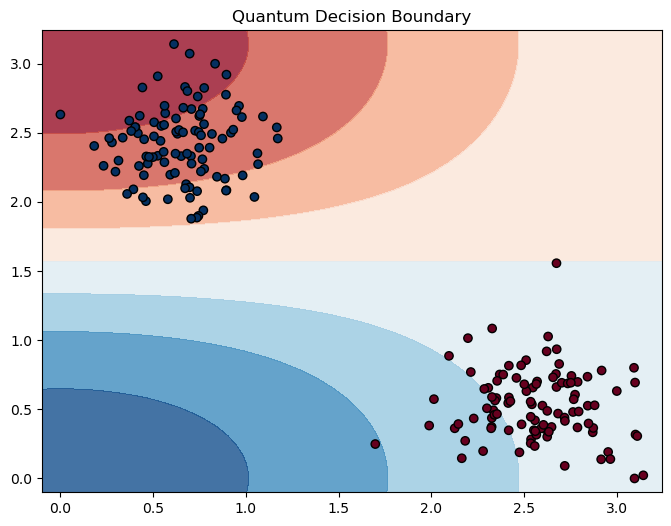

In [57]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # 1. Meshgrid 생성
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    # 2. 그리드 포인트 텐서 변환
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    
    # 3. 모델 예측
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy()
        
    # 4. 플롯 그리기
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu_r)
    plt.title("Quantum Decision Boundary")
    plt.show()

# 사용법 (X_scaled는 Numpy 배열이어야 함. 텐서라면 .cpu().numpy() 필요)
plot_decision_boundary(hybrid_model, X_scaled, y)

In [59]:
from sklearn.datasets import make_moons

# 1. 반달 모양 데이터 (직선으로 분리 불가능)
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# 2. 스케일링 (0 ~ pi)
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# 3. 텐서 변환
scaled = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).to(device)


qubit_count = 2
weight_dim = 2 # 혹은 4 (rx만 쓸거면 2)
# [중요] 쉬운 문제니까 shift는 작게 0.01
shift = torch.tensor(0.01, device=device) 

# Hamiltonian도 2큐비트에 맞게
hamiltonian = spin.z(0) + spin.z(1)
hybrid_model = Hybrid_QNN().to(device)

# 수정 제안
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.01) # Adam 추천, lr도 0.01 정도로 키워보세요

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in range(epochs):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(scaled).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_cost.item():.4f}.. "
            f"Train accuracy {training_accuracy[-1]:.4f}.. ", '\t',
            'quantum weights', hybrid_model.state_dict()['quantum.weights'][:5])

/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [32,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [33,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [55,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [107,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [114,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647352509/work/aten/

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


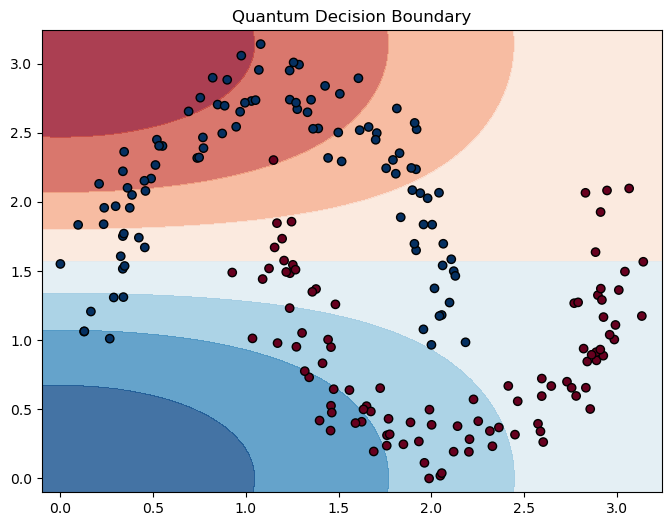

In [55]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # 1. Meshgrid 생성
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    # 2. 그리드 포인트 텐서 변환
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    
    # 3. 모델 예측
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy()
        
    # 4. 플롯 그리기
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu_r)
    plt.title("Quantum Decision Boundary")
    plt.show()

# 사용법 (X_scaled는 Numpy 배열이어야 함. 텐서라면 .cpu().numpy() 필요)
plot_decision_boundary(hybrid_model, X_scaled, y)

In [49]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, input_data: np.ndarray, weights: np.ndarray):
            qubits = cudaq.qvector(qubit_count)
            
            # --- 첫 번째 레이어 ---
            for q in range(qubit_count):
                ry(input_data[q], qubits[q])  # 데이터 인코딩
            
            # Entanglement (얽힘)
            for q in range(qubit_count):
                x.ctrl(qubits[q], qubits[(q + 1) % qubit_count])
                
            for q in range(qubit_count):
                rx(weights[q], qubits[q])     # 가중치 1 (앞부분)

            # --- 두 번째 레이어 (깊이 추가) ---
            # 여기서 weights 인덱싱을 잘 해야 합니다. 
            # 편의상 weights 배열을 [2 * qubit_count] 크기로 늘려서 사용한다고 가정
            
            for q in range(qubit_count):
                x.ctrl(qubits[q], qubits[(q + 1) % qubit_count]) # 얽힘 한번 더

            for q in range(qubit_count):
                # weights의 뒷부분 사용 (weights[q + qubit_count])
                # ry로 게이트를 섞어주는 것이 표현력에 더 좋음
                ry(weights[q + qubit_count], qubits[q])

        

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

        noise_model = cudaq.NoiseModel()
        depolarizing_channel = cudaq.DepolarizationChannel(0.01)
        noise_model.add_channel("rx", [0], depolarizing_channel)
        noise_model.add_channel('ry', [0], depolarizing_channel)
        self.noise_model = noise_model

    def run(self, input_data: torch.tensor, weights: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on inputs which moves thetas from GPU to CPU.

        batch_size = input_data.shape[0]

        # 1. qubit_count 리스트 생성 (배치 크기만큼)
        qubit_counts = [self.qubit_count for _ in range(batch_size)]

        # 2. Weights 확장 (Broadcasting)
        # weight_vals는 1차원 텐서지만, cudaq.observe에 넣을 때는 입력 데이터와 
        # 짝을 맞추기 위해 (Batch, Weight_Dim) 형태로 늘려줍니다.
        weight_vals_expanded = weights.expand(batch_size, -1).contiguous()

        # results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count, theta_vals, noise_model=self.noise_model)
        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_counts, input_data, weight_vals_expanded)
        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod # staticmethod로 인해서 외부에서 인스턴스 생성 없이 바로 사용이 가능함
    def forward(ctx, input_data: torch.tensor, weights: torch.tensor, quantum_circuit, shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        ctx.save_for_backward(input_data, weights)

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(input_data, weights).reshape(-1, 1)

        return exp_vals

    # @staticmethod # Gradient descent via finite difference
    # def backward(ctx, grad_output):
    #     """Backward pass computation via finite difference"""

    #     input_data, weights = ctx.saved_tensors
    #     shift = ctx.shift
    #     circuit = ctx.quantum_circuit

    #     # ==========================================
    #     # 2. Gradient w.r.t Weights (양자 파라미터 업데이트)
    #     # ==========================================
    #     # SPSA 방식 적용 (기존 코드 스타일 유지)
        
    #     # 섭동 벡터 생성 (+1 or -1)
    #     delta = torch.randint(0, 2, weights.shape, device=weights.device).float() * 2 - 1
        
    #     # 파라미터 섭동
    #     w_plus = weights + shift * delta
    #     w_minus = weights - shift * delta
        
    #     # 회로 실행 (input_data는 고정)
    #     # 주의: weights가 바뀌면 배치 전체 결과가 바뀝니다.
    #     out_w_plus = circuit.run(input_data, w_plus)
    #     out_w_minus = circuit.run(input_data, w_minus)
        
    #     # 변화량 계산 (Batch, 1)
    #     diff = (out_w_plus - out_w_minus).view(-1, 1)
        
    #     # 개별 샘플에 대한 기울기 추정 (Batch, Weight_Dim)
    #     # 브로드캐스팅: (Batch, 1) * (1, Weight_Dim)
    #     grad_per_sample = (diff / (2 * shift)) * delta.unsqueeze(0)
        
    #     # 최종 기울기: (Batch, 1) * (Batch, Weight_Dim) -> (Batch, Weight_Dim)
    #     # 그리고 배치 전체에 대해 합산(Sum) 또는 평균(Mean)을 내야 함 (일반적으로 Sum)
    #     grad_weight = (grad_output * grad_per_sample).sum(dim=0)

    #     # forward의 입력 순서에 맞춰서 반환: input, weights, circuit, shift
    #     return None, grad_weight, None, None


    @staticmethod
    def backward(ctx, grad_output):
        """
        Weights에 대해서만 유한 차분법으로 기울기 계산
        """
        input_data, weights = ctx.saved_tensors
        shift = ctx.shift
        circuit = ctx.quantum_circuit
        
        # =================================================================
        # [1번 위치] 루프 시작 전에 grad_output의 차원을 (Batch, 1)로 고정합니다.
        # =================================================================
        if grad_output.dim() == 1:
            grad_output = grad_output.view(-1, 1)

        
        # 1. Input Gradient: 계산 안 함 (None)
        grad_input = None 

        # 2. Weight Gradient: 유한 차분법을 위한 텐서 준비
        grad_weight = torch.zeros_like(weights)
        
        # 가중치 파라미터 하나하나에 대해 순회 (Loop)
        for i in range(weights.shape[0]):
            weights_p = weights.clone()
            weights_m = weights.clone()
            
            # i번째 파라미터 섭동
            weights_p[i] += shift
            weights_m[i] -= shift
            
            # 회로 실행
            out_p = circuit.run(input_data, weights_p) 
            out_m = circuit.run(input_data, weights_m) 
            
            # 유한 차분법 기울기 (Batch, 1) 형태로 확보
            grad_est = ((out_p - out_m) / (2 * shift)).view(-1, 1)
            
            # =================================================================
            # [2번 위치] 차원이 맞으므로 안전하게 곱셈 후 합산
            # (Batch, 1) * (Batch, 1) -> (Batch, 1) -> Sum -> 스칼라 값 저장
            # =================================================================
            grad_weight[i] = (grad_output * grad_est).sum()

        return grad_input, grad_weight, None, None


class QuantumLayer(nn.Module):
    """ 양자 회로를 양자 신경망 레이어로 활용 """

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator, weight_dim: int, shift: torch.Tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift


        self.weights = nn.Parameter(torch.rand(weight_dim))

    def forward(self, input):
        result = QuantumFunction.apply(input, self.weights, self.quantum_circuit, self.shift)
        # apply를 하면 forward와 backward가 자동으로 호출됨
        # QuantumFunction의 forward, backward 메서드가 staticmethod로 정의되어 있어서 인스턴스 생성 없이 바로 사용이 가능함
    

        return result

class Hybrid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hybrid_QNN, self).__init__()

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, weight_dim, shift)

    def forward(self, x):
        bs = x.shape[0]
        
        x = x.view(bs, -1)  # Turns images into vectors.

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = torch.sigmoid(self.quantum(x))

        return x.view(-1)
    

In [50]:
from sklearn.datasets import make_moons

# 1. 반달 모양 데이터 (직선으로 분리 불가능)
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# 2. 스케일링 (0 ~ pi)
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# 3. 텐서 변환
scaled = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).to(device)


qubit_count = 2
weight_dim = 4 # 혹은 4 (rx만 쓸거면 2)
# [중요] 쉬운 문제니까 shift는 작게 0.01
shift = torch.tensor(0.01, device=device) 

# Hamiltonian도 2큐비트에 맞게
hamiltonian = spin.z(0) + spin.z(1)
hybrid_model = Hybrid_QNN().to(device)

# 수정 제안
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.01) # Adam 추천, lr도 0.01 정도로 키워보세요

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in range(epochs):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(scaled).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_cost.item():.4f}.. "
            f"Train accuracy {training_accuracy[-1]:.4f}.. ", '\t',
            'quantum weights', hybrid_model.state_dict()['quantum.weights'][:5])

Epoch 10/1000.. Train loss: 0.8685.. Train accuracy 0.4700..  	 quantum weights tensor([ 0.6904,  0.3084,  0.5045, -0.0628], device='cuda:0')


KeyboardInterrupt: 

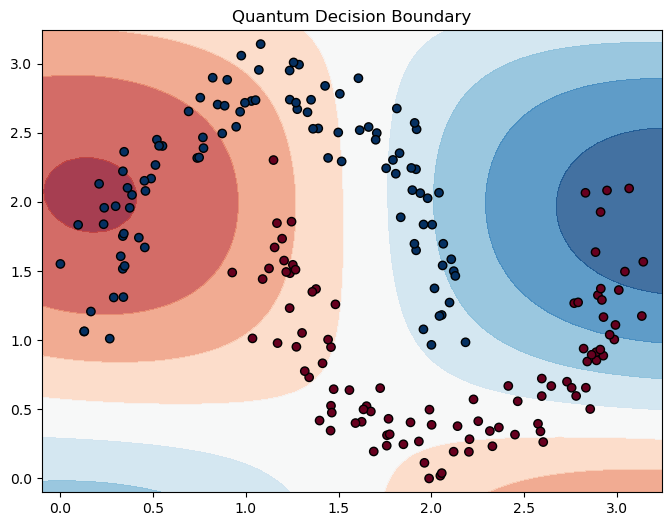

In [48]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # 1. Meshgrid 생성
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    # 2. 그리드 포인트 텐서 변환
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    
    # 3. 모델 예측
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy()
        
    # 4. 플롯 그리기
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu_r)
    plt.title("Quantum Decision Boundary")
    plt.show()

# 사용법 (X_scaled는 Numpy 배열이어야 함. 텐서라면 .cpu().numpy() 필요)
plot_decision_boundary(hybrid_model, X_scaled, y)

In [11]:
@cudaq.kernel # 이러한 데코레이터는 함수를 인수로 받는 함수를 나타냄.
def kernel(qubit_count: int, thetas: np.ndarray):
    qubits = cudaq.qvector(qubit_count)

    ry(thetas[0], qubits[0])
    rx(thetas[1], qubits[0])

cudaq.set_target('density-matrix-cpu')
qubit_counts = [1] * 1000
thetas = torch.randn(1000, 2)
result = cudaq.observe(kernel, spin.z(0), qubit_counts, thetas, noise_model=noise_model)

In [9]:
import sys
import os
sys.path.append(os.path.abspath('/home/ubuntu/latent'))
from QGAN.classical_model import Generator, Critic
from QGAN.quantum_model import Noisy_QNG

In [10]:
a =Noisy_QNG(4, 1)
n= torch.randn(10000, 4)

In [61]:
import torch
import numpy as np
import time
# 가정: QuantumFunction, QuantumLayer, Hybrid_QNN, device, qubit_count, hamiltonian, shift가 정의되어 있다고 가정

# 1. 모델 인스턴스 생성 및 평가 모드 설정
qubit_count = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudaq.set_target('density-matrix-cpu')
# cudaq.set_target('nvidia')
hybrid_model = Hybrid_QNN().to(device)
hybrid_model.eval() 


# 2. 배치 데이터 준비
BATCH_SIZE_LARGE = 500
BATCH_SIZE_SMALL = 10
INPUT_DIM = 28 * 28 # 입력 이미지 평탄화 차원 (28x28)

# 가짜 입력 데이터 생성 (실제 x_train의 형태를 모방)
# 각 입력은 fc5 레이어를 거쳐 2개의 파라미터(theta)를 출력합니다.
# QNN 입력은 (Batch_Size, 2) 형태여야 합니다.
# 여기서는 Hybrid_QNN의 전체 순전파를 테스트하기 위해 초기 입력 형태(28*28)로 생성합니다.

# 큰 배치 (500)
x_large = torch.randn(BATCH_SIZE_LARGE, INPUT_DIM).to(device)

# 작은 배치 (10)
x_small = torch.randn(BATCH_SIZE_SMALL, INPUT_DIM).to(device)

In [ ]:
# 3. 큰 배치 시간 측정 (500개)
qubit_count = 12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudaq.set_target('density-matrix-cpu')
# cudaq.set_target('nvidia')
hybrid_model = Hybrid_QNN().to(device)
hybrid_model.eval() 

with torch.no_grad():
    print(f"\n[테스트 시작] 큰 배치 (N={BATCH_SIZE_LARGE})")
    
    # 🚨 이 호출 내에서 QuantumFunction.run/run_and_grad가 한 번 실행되고, 
    # 내부에 있는 print("Quantum execution time...")이 출력됩니다.
    
    start_time_large = time.time()
    hybrid_model(x_large) 
    end_time_large = time.time()

# 4. 작은 배치 시간 측정 (10개)
with torch.no_grad():
    print(f"\n[테스트 시작] 작은 배치 (N={BATCH_SIZE_SMALL})")
    
    # QuantumFunction 내부의 시간 측정이 다시 출력됩니다.
    
    start_time_small = time.time()
    hybrid_model(x_small)
    end_time_small = time.time()


# 5. 결과 정리 및 비교
total_time_large = end_time_large - start_time_large
total_time_small = end_time_small - start_time_small

print("\n--- 전체 실행 시간 비교 ---")
print(f"큰 배치 (N={BATCH_SIZE_LARGE}) 전체 소요 시간: {total_time_large:.4f} 초")
print(f"큰 배치 (N={BATCH_SIZE_LARGE}) 평균 소요 시간: {total_time_large / BATCH_SIZE_LARGE:.4f} 초")
print(f"작은 배치 (N={BATCH_SIZE_SMALL}) 전체 소요 시간: {total_time_small:.4f} 초")
print(f"작은 배치 (N={BATCH_SIZE_SMALL}) 평균 소요 시간: {total_time_small / BATCH_SIZE_SMALL:.4f} 초")

In [ ]:
# 3. 큰 배치 시간 측정 (500개)

qubit_count = 12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# cudaq.set_target('density-matrix-cpu')
cudaq.set_target('nvidia')
hybrid_model = Hybrid_QNN().to(device)
hybrid_model.eval() 


with torch.no_grad():
    print(f"\n[테스트 시작] 큰 배치 (N={BATCH_SIZE_LARGE})")
    
    # 🚨 이 호출 내에서 QuantumFunction.run/run_and_grad가 한 번 실행되고, 
    # 내부에 있는 print("Quantum execution time...")이 출력됩니다.
    
    start_time_large = time.time()
    hybrid_model(x_large) 
    end_time_large = time.time()

# 4. 작은 배치 시간 측정 (10개)
with torch.no_grad():
    print(f"\n[테스트 시작] 작은 배치 (N={BATCH_SIZE_SMALL})")
    
    # QuantumFunction 내부의 시간 측정이 다시 출력됩니다.
    
    start_time_small = time.time()
    hybrid_model(x_small)
    end_time_small = time.time()


# 5. 결과 정리 및 비교
total_time_large = end_time_large - start_time_large
total_time_small = end_time_small - start_time_small

print("\n--- 전체 실행 시간 비교 ---")
print(f"큰 배치 (N={BATCH_SIZE_LARGE}) 전체 소요 시간: {total_time_large:.4f} 초")
print(f"큰 배치 (N={BATCH_SIZE_LARGE}) 평균 소요 시간: {total_time_large / BATCH_SIZE_LARGE:.4f} 초")
print(f"작은 배치 (N={BATCH_SIZE_SMALL}) 전체 소요 시간: {total_time_small:.4f} 초")
print(f"작은 배치 (N={BATCH_SIZE_SMALL}) 평균 소요 시간: {total_time_small / BATCH_SIZE_SMALL:.4f} 초")


[테스트 시작] 큰 배치 (N=5000)
Quantum execution time: 8.015891790390015 seconds

[테스트 시작] 작은 배치 (N=100)
Quantum execution time: 0.14815759658813477 seconds

--- 전체 실행 시간 비교 ---
큰 배치 (N=5000) 전체 소요 시간: 8.0264 초
큰 배치 (N=5000) 평균 소요 시간: 0.0016 초
작은 배치 (N=100) 전체 소요 시간: 0.1492 초
작은 배치 (N=100) 평균 소요 시간: 0.0015 초
